#1.)set up

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
from numpy import arange, sin, cos, pi
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
%matplotlib inline
import csv
import re

In [2]:
# Identitfy version of software used
pd.__version__

'0.17.0'

In [3]:
np.__version__

'1.10.1'

#2.)Load Data

In [4]:
#assign variables
#can't figure out how to make this an argument not hard code it 
length_of_file=12624
#table will store the each chunk of observation time data as an item in a list
table = []

In [5]:
#While loop to load data into a list by sepparating chunks by observation periods

def load_data(filepath):
    
    #Assign variables 
    #Length of data file 
    #length_of_file=12624
    #skipped rows is equal to the number of rows at the bottom of the file to skip
    skipped_footer = length_of_file
    #header row is equal to the row that contains the header for the data
    header_row = 10

    #Variable to tell me how many times the loop is ran 
    observation_periods=0

    #loops will continue to go, until all the data has been read
    while skipped_footer > 0:
        #shifts the skipped footer down the length of a table 
        skipped_footer -= 526
        #dataframe is the dataframe that contains the data
        dataframe = pd.read_table(filepath, sep='\s+', header=header_row, skipfooter = skipped_footer, engine='python')
        #appends the dataframe to the list
        table.append(dataframe)
        #Renamed Ampl(JY) to avoide syntax errors
        dataframe.columns=['Channel','IF','Polar','Frequency','Velocity','Amplitude','Phase']
        #converted Ampl from str(because of E) to float 
        dataframe['Amplitude']=dataframe[1:]['Amplitude'].astype(float)
        #shifts the header row to the next table in the data
        header_row += 523
        #count each time list is ran through
        observation_periods+=1

    #tell how many time list was ran through (tells me how many outputs I should get from now on)
    print(observation_periods)

In [6]:
load_data('/Users/sabrinadesoto/Documents/Sab_Final_Project/Data/antena.dat')

24


In [7]:
#I need some test to say if 511 rows should be printed for each data chunk

In [8]:
#check table holds right values
table[0].head()

Channel  IF Polar  Frequency  Velocity  Amplitude    Phase
0        1   1    RR  1720.8099         0        NaN      NaN
1        2   1    RR  1720.8093         0   0.000259    6.040
2        3   1    RR  1720.8087         0   0.000464  -95.605
3        4   1    RR  1720.8081         0   0.000522 -106.389
4        5   1    RR  1720.8075         0   0.000423  -20.039

In [9]:
#check all tables heads/values are changed
table[1].head()

Channel  IF Polar  Frequency  Velocity  Amplitude   Phase
0        1   1    RR  1720.8099         0        NaN     NaN
1        2   1    RR  1720.8093         0   0.000518  18.793
2        3   1    RR  1720.8087         0   0.000300  45.620
3        4   1    RR  1720.8081         0   0.000680 -47.248
4        5   1    RR  1720.8075         0   0.000460 -36.178

#step 3) make phase diagrams
Spike in the amplitude is the detection we care about. From that we can look at the phase pts that go with that spike.

In [10]:
#Make phase diagrams 

def make_phase_diagrams(table):
    '''Makes all the phase diagrams for every observation period using a while loop
    Input: table
    Output: phase diagrams for each chunk of data separated by observation period'''
    
    for chunk in table:
    
        #Plot Channel vs. phase/ampl. for all times
        #use multi-pannel plots stacked on eachother since they share the same x-axis
        plt.figure(figsize=(10,4))

        #top subplot is for phase data
        plt.subplot (2,1,1)
        plt.scatter(chunk.Frequency, chunk.Phase)
        plt.ylabel('Phase')
        #only one title since both subplots together make a phase diagram 
        plt.title('Phase Diagram')#if I could get the title to change for each one that'd be cool
    

        #bottom subplot is amplitude data
        plt.subplot (2,1,2)
        plt.plot(chunk.Frequency, chunk.Amplitude, color='g')
        #how do I get the scale to be numbers like 1720....#######
        plt.xlim(1720.48, 1720.82)
        #only one x-axis label since both subplots share the same x-axis
        plt.xlabel('Tuned Frequency (MHz)')
        plt.ylabel('Amplitude(Jy)')

        #NEEED A DIFFERENT WAY TO SAVE ALL PLOTS********************
        #plt.savefig('/Users/sabrinadesoto/Documents/Sab_Final_Project/Results/Phase_Diagrams.pdf')
        plt.show()
    

/Users/sabrinadesoto/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


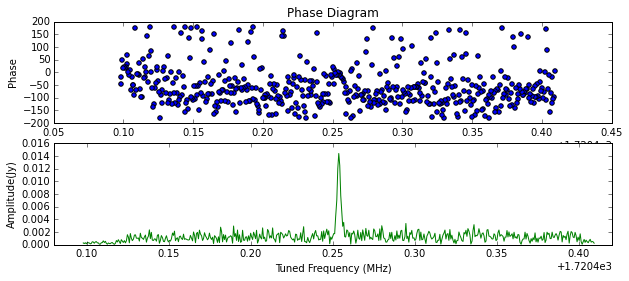

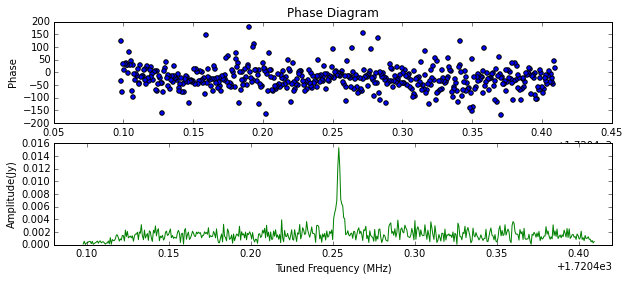

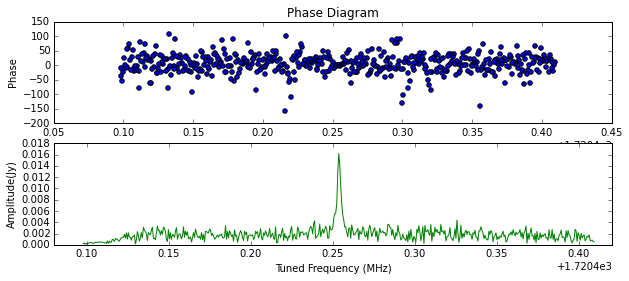

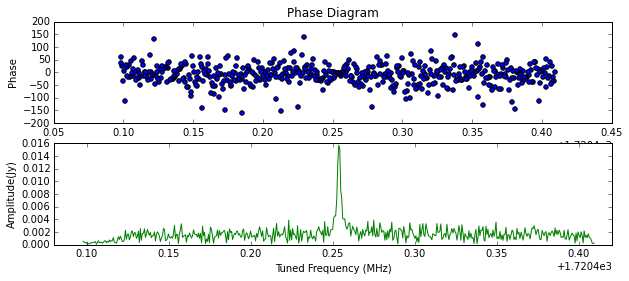

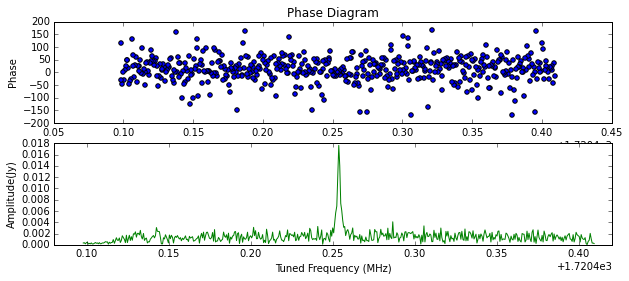

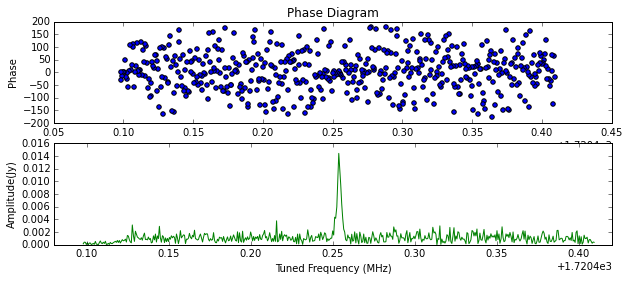

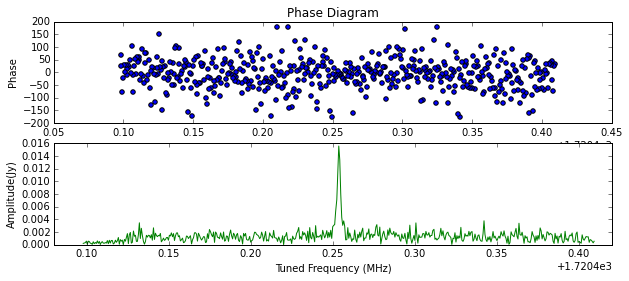

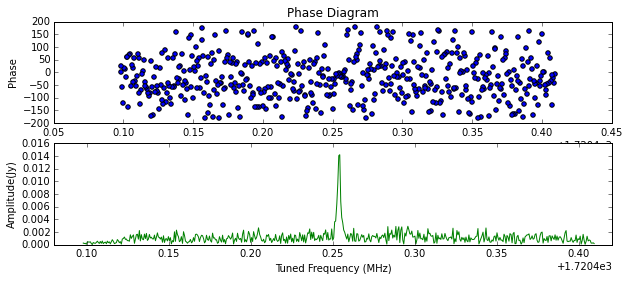

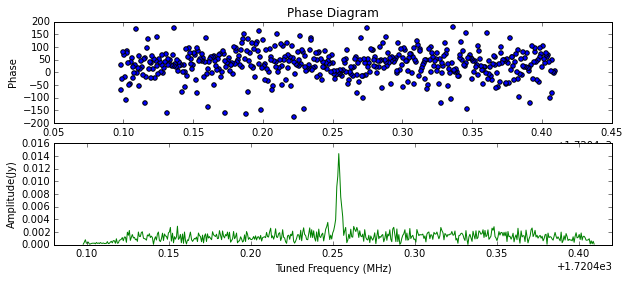

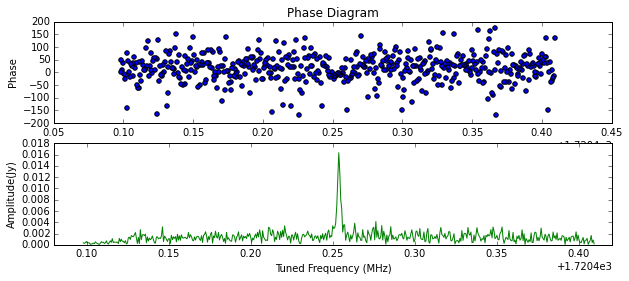

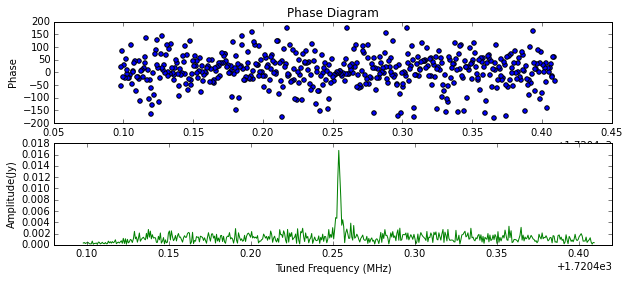

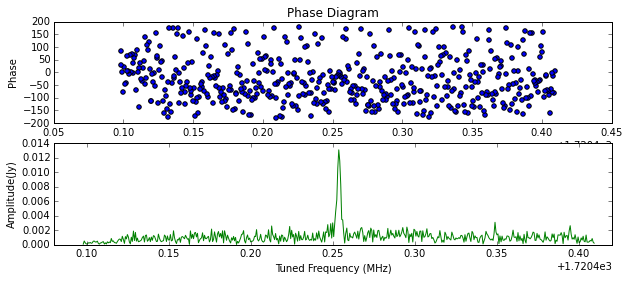

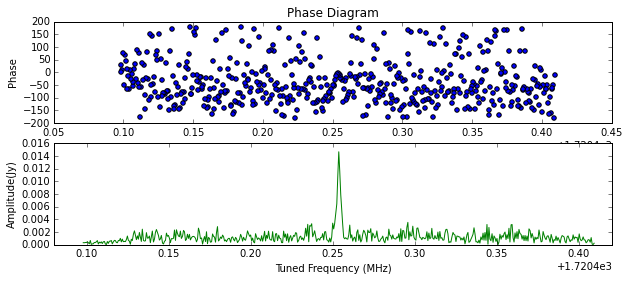

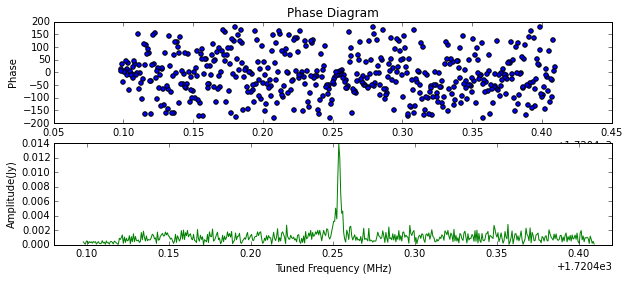

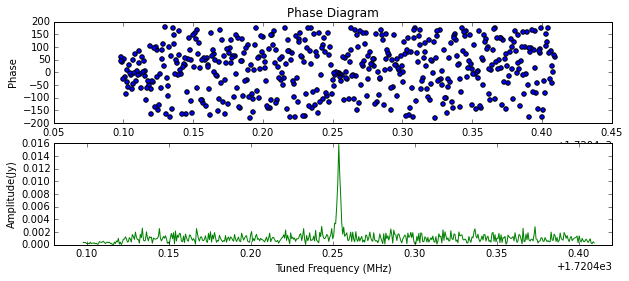

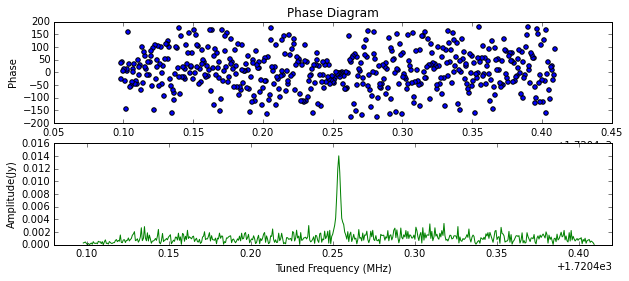

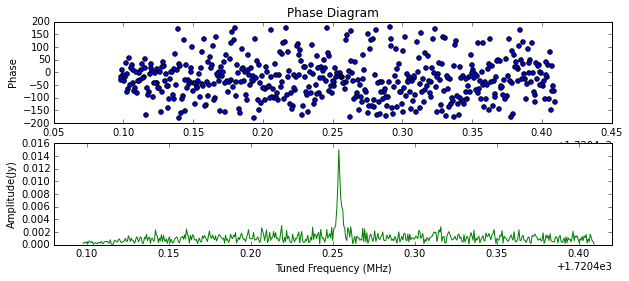

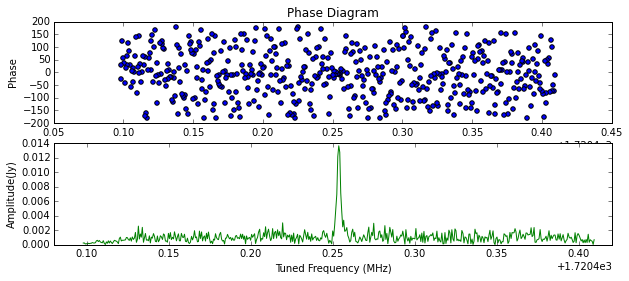

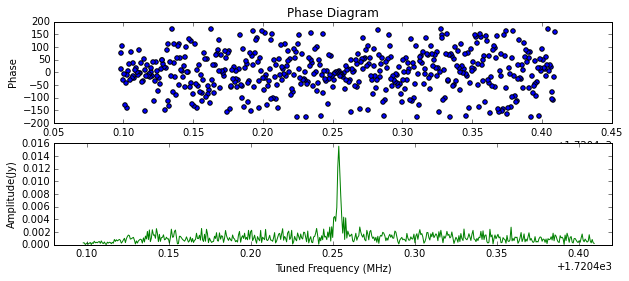

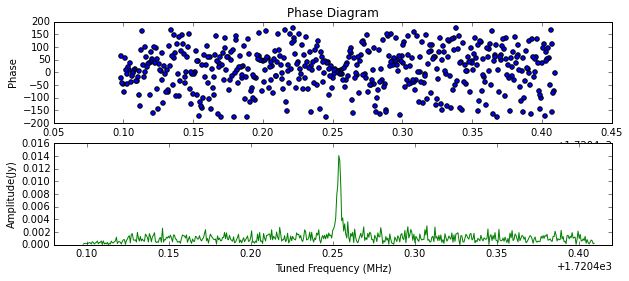

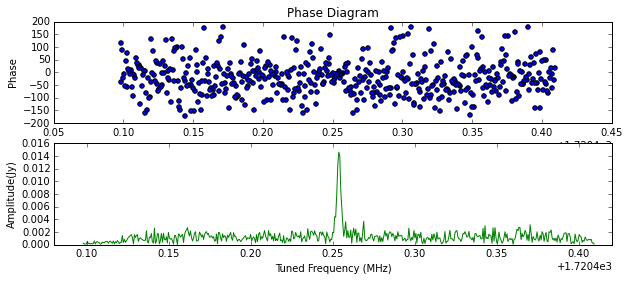

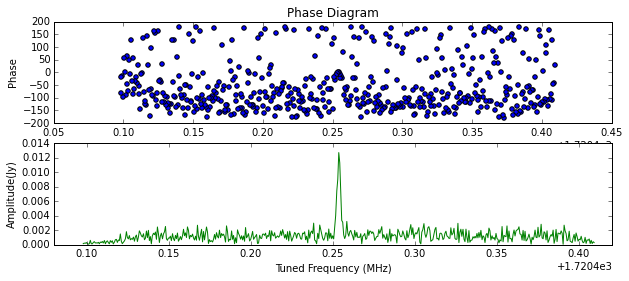

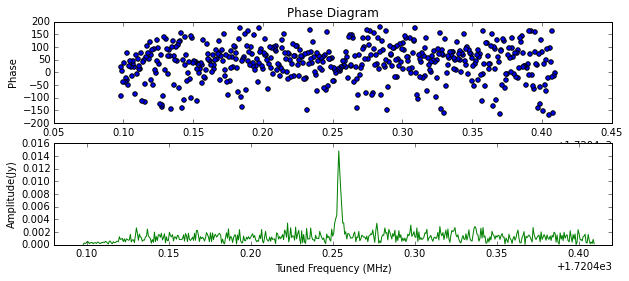

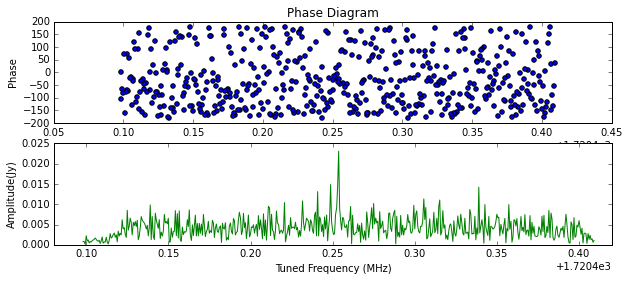

In [11]:
#show phase diagrams
make_phase_diagrams(table)

#step 4) Get Signal Phase from Data

In [12]:
#Start with basic function to return ampl. values > threshold 
def signal_amplitude(data, column):
    '''Function that reads through amplitudes and returns amplitudes > constant threshold
    Input:dataframe, datafram.column
    output:list of amplitudes > threshold'''
    
    #signal is defined as pts over a threshold value
    #define threshold value (here I just assigned one but should be done by stats or something)
    threshold_ampl=0.010
    
    #Create list to hold signal aplitudes
    signal_ampl_list = []
    for values in column: 
        if values >= threshold_ampl:
            #type(values) 
            #print(type(values))
            signal_ampl_list.append(values)
    return signal_ampl_list         

In [13]:
#Run loop that will get average signal phase for each observation time 
#and list them in a dataframe

def signal_phase(table):
    
    #create open lists for data
    #SA stores Signal Amplitude(SA) (Ampl>threshold) 
    SA = []
    #SD stores signal data (SD) (lines from table that correspond to a signal ampl)
    SD =[]
    #ASP stores average signal phase (ASP)  
    ASP =[]
    
    for chunk in table:
    
        #STEP 4)
        #run function on all data to get signal amplitudes
        signal_amplitude(chunk, chunk.Amplitude)
        #asign signal amplitudes to list SA
        x = signal_amplitude(chunk, chunk.Amplitude)
        sig_ampl=pd.DataFrame({'Amplitude':x})
        SA.append(sig_ampl)
    
        #STEP 5)
        #merge all data with signal amps data (from step above) to get rows for detection ampl only
        signal_data= pd.merge(chunk, sig_ampl, on='Amplitude')
        SD.append(signal_data)
    
        #STEP 6)
        #Average phase values
        Ave_phase=signal_data['Phase'].mean()
        #send values to a list
        ASP.append(Ave_phase)
        #save list of average phase value for each observation period to a dataframe
        ave_sig_phase=pd.DataFrame({'ave_phase':ASP}) 
        #make sure values are floats
        ave_sig_phase['ave_phase']=ave_sig_phase['ave_phase'].astype(float)
        #add phase location column to dataframe
        ave_sig_phase['Phase_location']=ave_sig_phase/360

    #STEP 8)
    #return completed table of average signal phases defined as new variable 
    #phase_results=signal_phase(table)
    #return phase_results
    return(ave_sig_phase.head())

In [14]:
signal_phase(table)

ave_phase  Phase_location
0  -7.689667       -0.021360
1  -7.027667       -0.019521
2  -1.616500       -0.004490
3  -3.745000       -0.010403
4   1.871000        0.005197

In [15]:
phase_results=signal_phase(table)
phase_results.head()

ave_phase  Phase_location
0  -7.689667       -0.021360
1  -7.027667       -0.019521
2  -1.616500       -0.004490
3  -3.745000       -0.010403
4   1.871000        0.005197

#step 5) plot fringe size for each observational period

In [16]:
#make function for fringe plots of all observation periods
def fringe_plots(fringe_filepath):
    '''input: pathway to fringe data as a string'''
    
    #load fringe data
    fringe_data=pd.read_excel(fringe_filepath, sep=',')
    #resample fringe data
    Fringe_small_data= fringe_data[['Obv_time', 'wavelen/OD']]
    #combine fringe data with phase results from signal_phase
    fringe_plot_data=pd.concat([Fringe_small_data, phase_results], axis=1)
    #save dataframe to results...
    #fringe_plot_data.to_csv('/Users/sabrinadesoto/Documents/Sab_Final_Project/Results/MASER_fringe_data.cvs', delimiter=',')
    
    for value in fringe_plot_data['wavelen/OD']:
        ax1= plt.subplot()
            #ax2=ax1.twinx()

            #i=arange(1,1024)
            #n=-1+(20/1000)*i

            #k=arange(xmin, xmax, incriment=wavelen/OD?)
        k=arange(-1.0, 1.0, value)

        ax1.plot(k, sin(2*pi*k))
        ax1.set_xlim((-1.0, 1.0))
        ax1.set_ylim((-1.5, 1.5))
        ax1.set_yticks([])
        ax1.set_title('Observation Period Fringe')

        show()


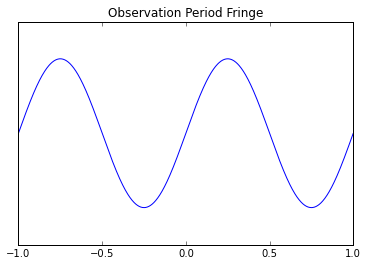

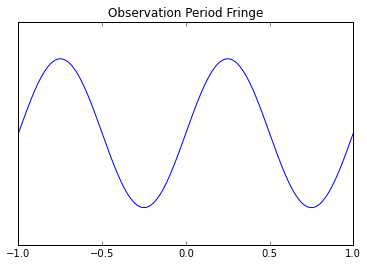

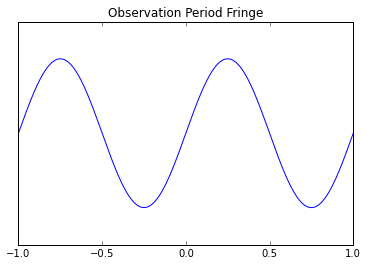

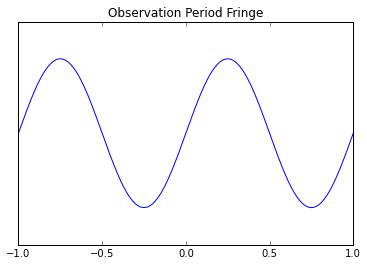

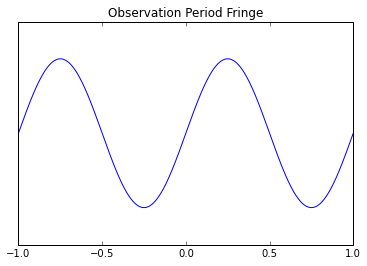

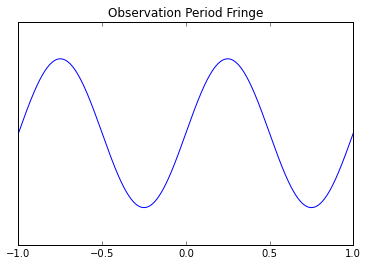

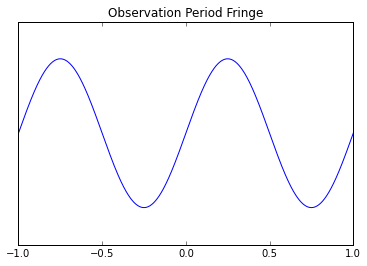

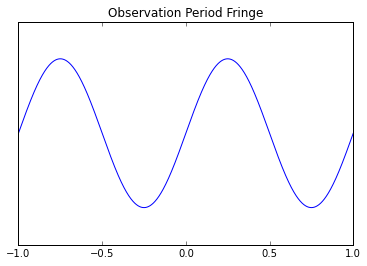

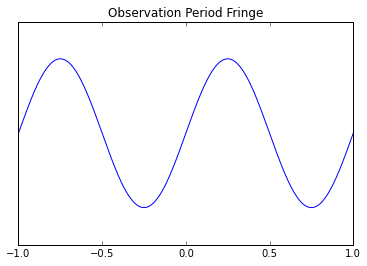

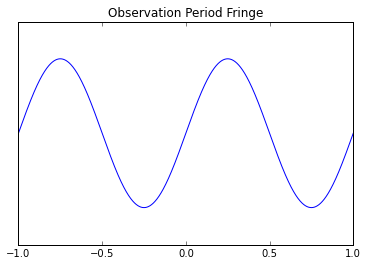

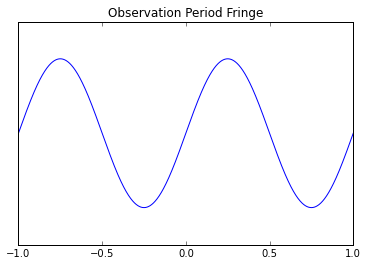

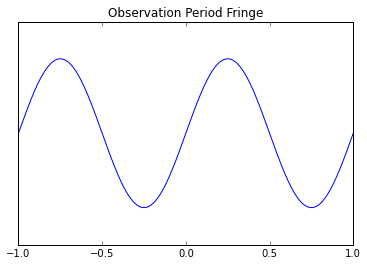

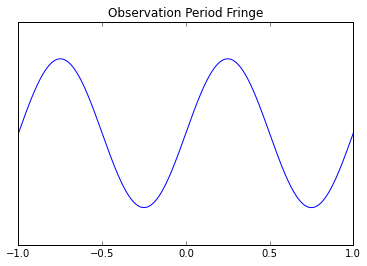

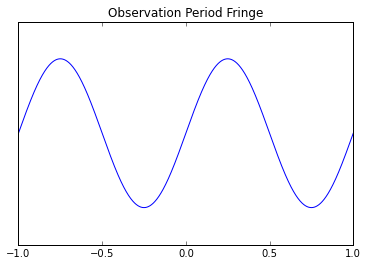

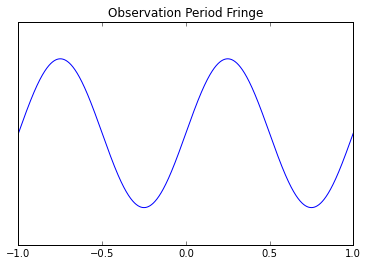

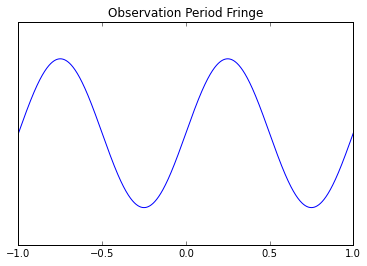

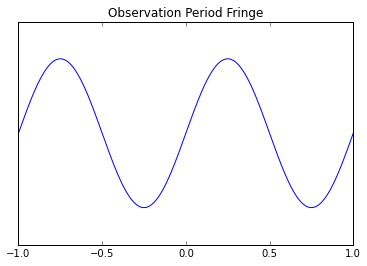

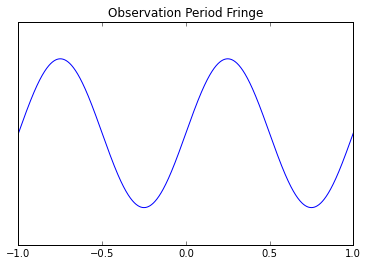

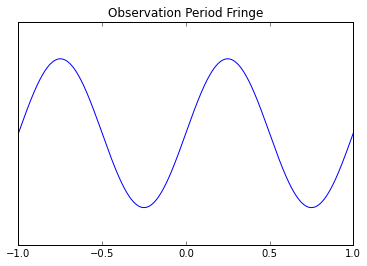

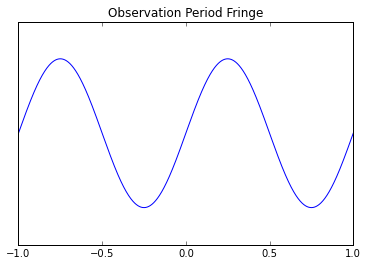

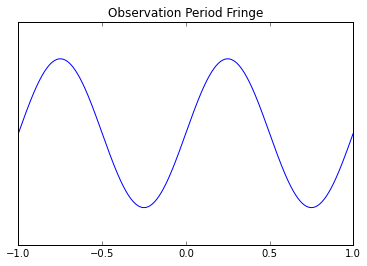

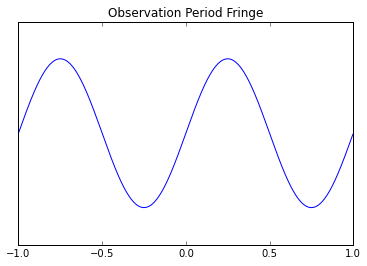

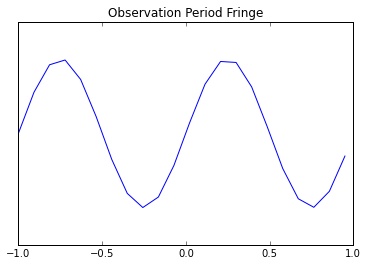

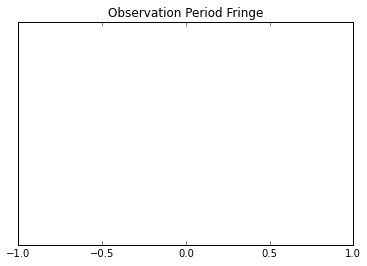

In [18]:
fringe_plots('/Users/sabrinadesoto/Documents/Sab_Final_Project/Data/New_data/Fringe_data.xlsx')